In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Team Member Exit Analysis – Zela Nails

This notebook explores the underlying patterns that may explain why several team members at Zela Nails left the salon. Our goal was to identify behavioral and performance traits shared by those who quit, and use those insights to assess retention risk for current employees.

## Analysis Process Overview
1. **Monthly Service & Sales Trends**
    - Analyzed each leaver's service volume over time to detect burnout patterns, gradual declines, or abrupt drop-offs before exit.
2. **Service Category Participation**
    - Measured how many service categories each team member regularly performed to assess specialization vs. variety.
3. **Client Loyalty / Retention Ratio**
    - Calculated how well each team member built relationships with clients based on repeat visits (total services ÷ unique clients).
4. **Comparison with Current Team Members (see result on dashboard)**
    - Evaluated whether current staff are showing similar patterns to those who left.
5. **Threshold Building & Risk Scoring (see result on dashboard)**
    - Created data-driven thresholds (like average drop % from past leavers), and scored current team members based on:
        - **Retention Ratio**
        - **Monthly Service Drop**
        - **Category Variety**
        - **Average Monthly Load**
6. **Final Output: Risk Monitoring System (see result on dashboard)**
    - Built a function that flags current team members as Low, Medium, or High Risk for potential turnover.

In [4]:
# function to read data from SQLite database
def get_db_connection():
    """Create a database connection and return the connection object"""
    conn = sqlite3.connect('zela_nails.sqlite')
    conn.row_factory = sqlite3.Row  # This allows accessing columns by name
    return conn

def query_db(query, args=(), one=False):
    """Query the database and return results as dictionaries"""
    conn = get_db_connection()
    try:
        cur = conn.cursor()
        cur.execute(query, args)
        rv = [dict(row) for row in cur.fetchall()]
        conn.commit()
        return (rv[0] if rv else None) if one else rv
    finally:
        conn.close()

In [6]:
#Team members who quit
leavers = ['Bris', 'Evelyn','Hadel','Mary','Favi',
            'XImena','Anahi','Adalu','Karla','Rocio','Lily', 'Celeste']

## Monthly Service & Sales Trends

In [9]:
# Monthly Service & Sales Trends
query = """
    SELECT 
    "Team member" AS teamMember,
    strftime('%Y-%m', Date) AS month,
    COUNT(*) AS serviceCount,
    SUM("Total sales") AS totalSales
    FROM sales_data
    WHERE Store = ?
    AND "Team member" IN (
    'Bris', 'Evelyn','Hadel','Mary','Favi',
    'XImena','Anahi','Adalu','Karla','Rocio','Lily', 'Celeste')
    GROUP BY teamMember, month
    ORDER BY teamMember, month;
    """
args= (1,)
result = query_db(query,args)

In [11]:
df = pd.DataFrame(result)
df['month'] = pd.to_datetime(df['month'])
df.head()

,teamMember,month,serviceCount,totalSales
0,Adalu,2023-01-01,205,25992
1,Adalu,2023-02-01,189,27233
2,Adalu,2023-03-01,209,27573
3,Adalu,2023-04-01,331,36383
4,Adalu,2023-05-01,331,39788


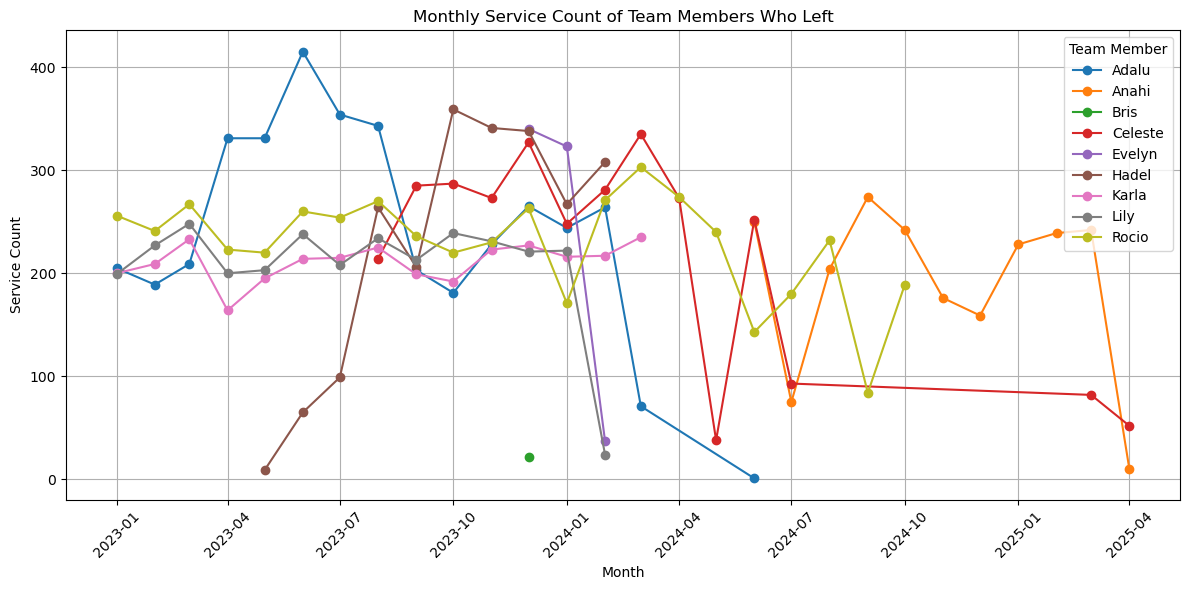

In [17]:
# Create monthly service count plot
plt.figure(figsize=(12, 6))

# Plot one line per team member
for member in df['teamMember'].unique():
    member_df = df[df['teamMember'] == member]
    plt.plot(member_df['month'], member_df['serviceCount'], marker='o', label=member)

# Add labels and legend
plt.title("Monthly Service Count of Team Members Who Left")
plt.xlabel("Month")
plt.ylabel("Service Count")
plt.legend(title="Team Member")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

### Monthly Service Trends of Team Members Who Left
This chart visualizes the monthly service volume of team members who left Zela Nails. Each line represents one former employee's performance over time.

By analyzing individual service patterns, we can detect signs of burnout, disengagement, or sudden exits — helping us build a data-driven understanding of turnover behavior.

Key Observations:

- Evelyn, Lily, Karla: Sudden drop after Jan 2024 → likely resignation or internal shift.

- Adalu: High-volume performer who burned out → sharp decline after peak.

- Rocio & Anahi: Irregular monthly activity → scheduling or consistency issues.

- Hadel & Celeste: Late joiners with strong starts, but dropped off mid–2024.

- Many team members showed a noticeable decline in services performed in the months leading up to their departure

## Service Category Participation

In [35]:
#Service Category Counts Per Team Member
query = """
    SELECT
    "Team member" AS teamMember,
     Category,
     COUNT(*) AS serviceCount,
     ROUND(SUM("Total sales"), 2) AS totalSales
     FROM sales_data
     WHERE Store = ?
         AND "Team member" IN (
        'Bris', 'Evelyn','Hadel','Mary','Favi',
        'XImena','Anahi','Adalu','Karla','Rocio','Lily', 'Celeste')
    GROUP BY teamMember, Category
    ORDER BY teamMember, serviceCount DESC;
    """
args= (1,)
result2 = query_db(query,args)

In [37]:
df2 = pd.DataFrame(result2)
df2.head()

,teamMember,Category,serviceCount,totalSales
0,Adalu,Manicure / Pedicure,2408,265100.0
1,Adalu,Acrylic,969,183210.0
2,Adalu,Gel / Regular Polish,154,14376.0
3,Adalu,Retiros,122,8540.0
4,Adalu,Designs,101,7570.0


In [39]:
pivot_df = df2.pivot_table(
    index='teamMember', 
    columns='Category', 
    values='serviceCount', 
    aggfunc='sum', 
    fill_value=0
)

In [41]:
pivot_df= pivot_df[['Acrylic', 'Designs', 'Extras', 'Eyelashes and Eyebrows',
       'Gel / Regular Polish', 'Hair', 'Hair Removal', 'Manicure / Pedicure',
       'Other', 'Retiros']]

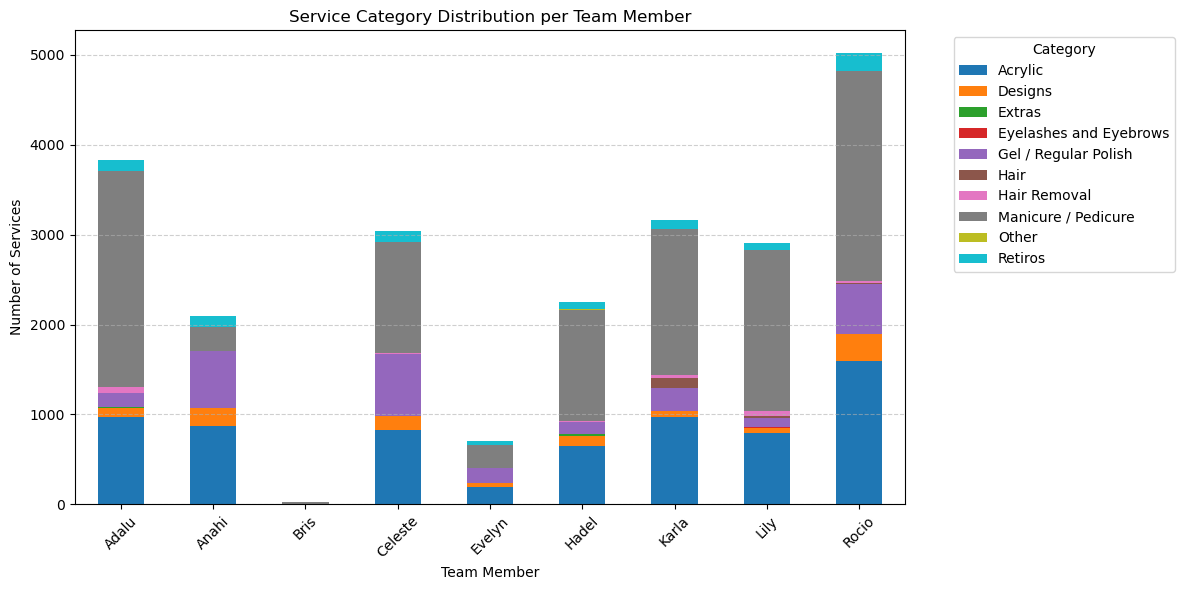

In [43]:
# Set figure size
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add labels
plt.title('Service Category Distribution per Team Member')
plt.xlabel('Team Member')
plt.ylabel('Number of Services')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.show()

### Service Specialization Amoung Members Who Left

This chart displays the number of services performed per category for each team member who left Zela Nails. It helps us understand their level of specialization vs. variety and potential workload imbalances.

Key Takeaways:
- Specialists = Higher Risk
  - Team members like Evelyn, Karla, Lily, Rocio were highly focused on Manicure/Pedicure, with little variety — making them more
    prone to burnout or boredom.
- Generalists Showed Flexibility
  - Celeste, Anahi, and Adalu handled multiple service types (e.g., Gel, Acrylic, Designs), indicating greater adaptability and
    engagement.

## Client Loyalty / Retention Ratio

In [48]:
# Client Loyalty / Retention Ratio Analysis
query = """
    SELECT
    "Team member" AS teamMember,
    COUNT(*) AS totalAppointments,
    COUNT(DISTINCT Client) AS uniqueClients,
    ROUND(CAST(COUNT(*) AS FLOAT) / COUNT(DISTINCT Client), 2) AS retentionRatio
    FROM sales_data
    WHERE Store = ?
         AND "Team member" IN (
        'Bris', 'Evelyn','Hadel','Mary','Favi',
        'XImena','Anahi','Adalu','Karla','Rocio','Lily', 'Celeste')
    GROUP BY "Team member"
    ORDER BY retentionRatio ASC;
    """
args= (1,)
result3 =query_db(query,args)

In [50]:
df3 = pd.DataFrame(result3)
df3

,teamMember,totalAppointments,uniqueClients,retentionRatio
0,Bris,22,14,1.57
1,Evelyn,700,419,1.67
2,Celeste,3040,1417,2.15
3,Anahi,2099,955,2.20
4,Karla,3164,1349,2.35
5,Hadel,2256,948,2.38
6,Adalu,3834,1452,2.64
7,Lily,2907,1098,2.65
8,Rocio,5027,1754,2.87


**Low Ratio (<1.5): Weak Engagement / Risk of Early Exit**
- Bris and Evelyn likely didn’t build deep client relationships
- They may have left due to lack of bookings, mismatch with clients, or dissatisfaction
  
**Middle Tier (1.5–2.5): Stable but Replaceable**
- Celeste, Anahi, Karla, Hadel fall in the middle
- These are solid performers who likely left for external reasons (pay, management, schedule)
    
**High Ratio (2.6+): Highly Valued + Mobile**
- Adalu, Lily, Rocio had the strongest loyalty from clients
- These are likely the most influential leavers
- They had the most to lose and the most to gain — possibly left to:
    - Go independent
    - Start their own service brand
    - Take clients with them


## Conclusion: Common Traits Among Team Members Who Left

After analyzing the behavioral patterns of former employees at Zela Nails, we identified three recurring risk indicators that were present in multiple team members who eventually left:

1. Monthly Service Drop:

    Many team members showed a noticeable decline in services performed in the months leading up to their departure — often greater
    than 30–35% compared to their average volume.

    - Benchmark for risk:
    
        monthlyDrop > 30% is considered a potential burnout or disengagement flag.
      
2. Limited Service Variety

    Leavers tended to work within 1–2 categories, often specializing in Manicure/Pedicure. This lack of variety may lead to boredom,
    fatigue, or skill stagnation.

    - Benchmark for risk:
   
       numCategories <= 2 is flagged as over-specialized.
      
3. Client Retention Extremes

    We observed that some leavers had very low retention ratios (<2.0) — indicating disengagement, while others had very high ratios
    (>2.6) — suggesting they had built a loyal base and may have left to start independently.

    - Benchmark for risk:
    
        retentionRatio < 2.0 or > 2.6 is considered a risk range.